In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [3]:
# Dataset link: https://drive.google.com/drive/folders/1xJXzSEsb_fL4Tzm7M1t_vI_0uPKdzl_7?usp=sharing
os.chdir('./drive/My Drive/signature_data')

In [4]:
!ls

test_data  train_data  validation_data


#Dataset

In [5]:
def get_data(dir, labels):
    features = []
    targets = []
    for name in tqdm(sorted(os.listdir(dir))):
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = cv2.imread(dir+'/'+name+'/'+image_name)#, cv2.IMREAD_GRAYSCALE)
            features.append(img)
            if labels:
                if 'forg' in name.lower():
                    targets.append(1)
                else:
                    targets.append(0)
    if labels:
        return np.array(features),np.array(targets)
    else:
        return np.array(features)

In [6]:
train_features, train_labels = get_data('train_data', True)
validation_features, validation_labels = get_data('validation_data', True)
test_features, test_labels = get_data('test_data', True)

100%|██████████| 128/128 [00:01<00:00, 81.85it/s]


In [7]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(826, 268, 650, 3)
(413, 268, 650, 3)
(410, 268, 650, 3)


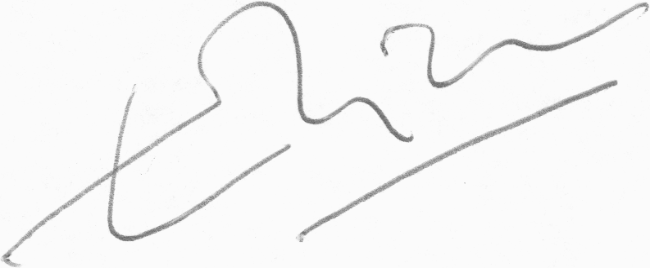

In [8]:
cv2_imshow(train_features[4])

In [9]:
train_features = train_features.reshape((826, 268, 650, 3))
train_features = train_features.astype('float32') / 255
validation_features = validation_features.reshape((413, 268, 650, 3))
validation_features = validation_features.astype('float32') / 255
test_features = test_features.reshape((410, 268, 650, 3))
test_features = test_features.astype('float32') / 255

#Creating the Model

In [10]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(268, 650, 3))
for k,v in  conv_base._get_trainable_state().items():
    k.trainable = False

In [11]:
from keras import layers
from keras import models
from keras import optimizers

end_model = models.Sequential()
end_model.add(layers.Flatten(input_shape=conv_base.output_shape[1:]))
end_model.add(layers.Dense(64, activation='relu'))
end_model.add(layers.Dense(64, activation='relu'))
end_model.add(layers.Dense(1, activation='sigmoid'))

model = models.Model(inputs=conv_base.input, outputs=end_model(conv_base.output))
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

#Training the Model

In [12]:
history = model.fit(train_features, train_labels, epochs=100, batch_size=32, validation_data=(validation_features, validation_labels))

Epoch 1/100
26/26 [==============================] - 34s 1s/step - loss: 0.7882 - accuracy: 0.4692 - val_loss: 0.7090 - val_accuracy: 0.4722
Epoch 2/100
26/26 [==============================] - 21s 832ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6790 - val_accuracy: 0.5860
Epoch 3/100
26/26 [==============================] - 22s 849ms/step - loss: 0.6660 - accuracy: 0.6247 - val_loss: 0.6675 - val_accuracy: 0.6247
Epoch 4/100
26/26 [==============================] - 22s 854ms/step - loss: 0.6551 - accuracy: 0.6918 - val_loss: 0.6599 - val_accuracy: 0.6368
Epoch 5/100
26/26 [==============================] - 22s 865ms/step - loss: 0.6471 - accuracy: 0.7163 - val_loss: 0.6524 - val_accuracy: 0.6513
Epoch 6/100
26/26 [==============================] - 22s 872ms/step - loss: 0.6364 - accuracy: 0.7342 - val_loss: 0.6454 - val_accuracy: 0.6683
Epoch 7/100
26/26 [==============================] - 23s 879ms/step - loss: 0.6302 - accuracy: 0.7638 - val_loss: 0.6395 - val_accuracy: 0.

#Plotting results

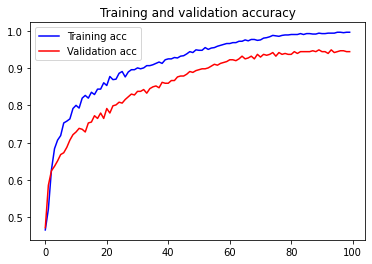

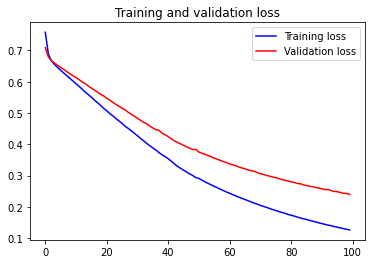

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#Checking accuracy of Test set

In [14]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
test_acc

13/13 [==============================] - 7s 568ms/step - loss: 0.2598 - accuracy: 0.9390


0.9390243887901306

#Saving the Model

In [15]:
model.save('signature_forgery_vgg16.h5')